In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from datetime import timedelta 

In [2]:
ratio = 1
buy_at = 0.01
fees = 0.0
from_year = "2020-01-01"

asset1 = yf.Ticker("0Z4S.IL").history(period='max')[from_year:]
hkdeur = yf.Ticker("HKDEUR=X").history(period='max')[from_year:].Close
hkdeur.index = hkdeur.index.tz_convert("Europe/Berlin")-timedelta(hours=1)
asset2 = yf.Ticker("NNND.F").history(period='max')[from_year:]
asset2["hkdeur"] = hkdeur
asset2.hkdeur.fillna(method='ffill', inplace=True)
asset2 = asset2.multiply(1/asset2.hkdeur, axis=0)
asset2.index = asset2.index.tz_convert("UTC") + timedelta(hours=1)

asset1, asset2

(                                 Open        High         Low       Close  \
 Date                                                                        
 2020-01-02 00:00:00+00:00  377.885780  377.885780  377.885780  357.206268   
 2020-01-03 00:00:00+00:00  384.346853  384.346853  384.346853  357.206268   
 2020-01-06 00:00:00+00:00  374.347794  374.347794  374.347794  357.206268   
 2020-01-07 00:00:00+00:00  357.206268  357.206268  357.206268  357.206268   
 2020-01-08 00:00:00+00:00  377.985580  378.476642  377.985580  357.206268   
 ...                               ...         ...         ...         ...   
 2023-01-16 00:00:00+00:00  369.748535  369.748535  369.748535  369.748535   
 2023-01-17 00:00:00+00:00  373.799988  373.799988  373.799988  373.799988   
 2023-01-18 00:00:00+00:00  379.473663  379.473663  379.473663  379.473663   
 2023-01-19 00:00:00+00:00  379.473663  379.473663  379.473663  379.473663   
 2023-01-20 00:00:00+00:00  391.256714  391.257385  386.985657  

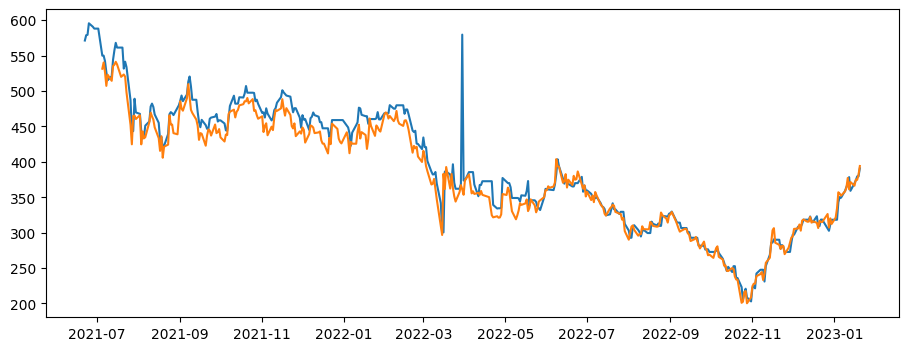

In [3]:
plt.figure(figsize=(11, 4))
plt.plot(asset1.Close[-400:])
plt.plot(asset2.Close[-400:])
plt.show()

In [4]:
delta = (asset2.Close - asset1.Close)/asset2.Close
asset2["delta"] = delta
for pct in [0.005, 0.01]:
    print(f"Percent timesteps difference bigger than {pct*100}%: {(delta.abs()>=pct).sum()/len(delta)*100}%")

Percent timesteps difference bigger than 0.5%: 89.59390862944161%
Percent timesteps difference bigger than 1.0%: 83.88324873096447%


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


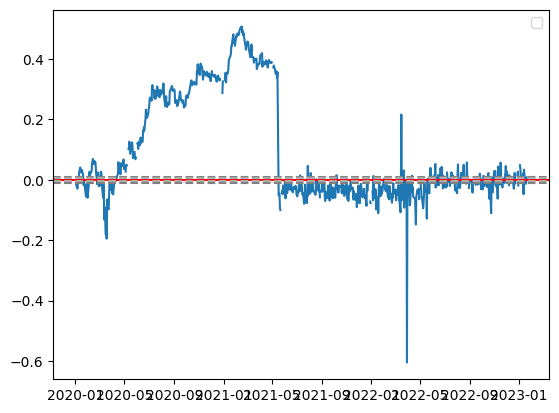

In [5]:
plt.plot(delta)
plt.axhline(0.0, color='red')
plt.axhline(0.01, color='grey', linestyle = '--')
plt.axhline(-0.01, color='grey', linestyle = '--')
plt.axhline(0.005, color='darkgrey', linestyle = '--')
plt.axhline(-0.005, color='darkgrey', linestyle = '--')
plt.legend()
plt.show()

In [6]:
asset2["returns_asset2"] = np.log(1+asset2.Close.pct_change())
asset2["returns_asset1"] = np.log(1+asset1.Close.pct_change())
asset2 = asset2.dropna().replace([np.inf, -np.inf], 0.0)
asset2.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,hkdeur,delta,returns_asset2,returns_asset1
Date,,,,,,,,,,,
2020-01-03 00:00:00+00:00,352.041988,352.161508,346.782874,350.607681,128214.055888,0.0,0.0,1.0,-0.018820,-0.018014,0.0
2020-01-06 00:00:00+00:00,344.430396,347.174713,340.890640,347.134931,219022.800396,0.0,0.0,1.0,-0.029013,-0.009954,0.0
2020-01-07 00:00:00+00:00,354.647110,356.559581,352.296327,356.559581,218943.617232,0.0,0.0,1.0,-0.001814,0.026788,0.0
2020-01-08 00:00:00+00:00,347.947792,357.124196,347.947792,357.124196,219140.410942,0.0,0.0,1.0,-0.000230,0.001582,0.0
2020-01-09 00:00:00+00:00,356.067316,359.312205,354.880149,357.650165,364587.026438,0.0,0.0,1.0,0.001241,0.001472,0.0


In [7]:
arbitrage = False
delta_sign = 0
returns = []
position_row = None
for index, row in asset2.iterrows():
    if not arbitrage and np.abs(row.delta) >= buy_at:
        arbitrage = True
        delta_sign = np.sign(row.delta)
        position_row = asset2.iloc[asset2.index.get_loc(index)+1]
    if arbitrage and delta_sign*row.delta <= 0.0:
        cum_return = -delta_sign*asset2.returns_asset2[position_row.name:row.name].sum()+delta_sign*asset2.returns_asset1[position_row.name:row.name].sum()
        returns.append((position_row.name, row.name, cum_return-fees))
        arbitrage = False
        delta_sign = 0
returns_df = pd.DataFrame(returns, columns=["open_date", "end_date", "return"])
returns_df

,open_date,end_date,return
0,2020-01-06 00:00:00+00:00,2020-01-09 00:00:00+00:00,0.019887
1,2020-01-13 00:00:00+00:00,2020-01-21 00:00:00+00:00,0.042535
2,2020-01-24 00:00:00+00:00,2020-02-04 00:00:00+00:00,0.039242
3,2020-02-06 00:00:00+00:00,2020-02-24 00:00:00+00:00,0.029245
4,2020-02-27 00:00:00+00:00,2020-02-27 00:00:00+00:00,0.026077
...,...,...,...
61,2022-12-30 00:00:00+00:00,2022-12-30 00:00:00+00:00,0.046046
62,2023-01-04 00:00:00+00:00,2023-01-09 00:00:00+00:00,0.052081
63,2023-01-12 00:00:00+00:00,2023-01-12 00:00:00+00:00,0.067900
64,2023-01-16 00:00:00+00:00,2023-01-16 00:00:00+00:00,0.043428


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


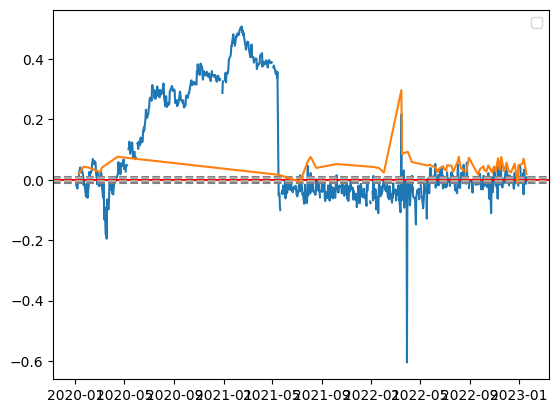

In [8]:
plt.plot(delta)
plt.axhline(0.0, color='red')
plt.axhline(0.01, color='grey', linestyle = '--')
plt.axhline(-0.01, color='grey', linestyle = '--')
plt.axhline(0.005, color='darkgrey', linestyle = '--')
plt.axhline(-0.005, color='darkgrey', linestyle = '--')
plt.plot(returns_df.end_date, np.exp(returns_df['return'])-1)
plt.legend()
plt.show()

In [9]:
print(f"Return: {(np.exp(returns_df['return'])).product()*100}%")

Return: 1886.5137376624837%
